In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from random import sample, choices, random
from typing import List, Tuple
import matplotlib.pyplot as plt

In [3]:
def route_distance(route: List[Tuple[float, float, float]]) -> float:
    return sum(euclidean(route[i], route[i+1]) for i in range(len(route) - 1))


In [4]:
def initialize_population(pop_size, grouped_points) -> List[List[Tuple[float, float, float]]]:
    population = []
    for _ in range(pop_size):
        individual = []
        for group, points in grouped_points:
            points_list = points[['X', 'Y', 'Z']].values.tolist()
            individual.extend(sample(points_list, len(points_list))) 
        population.append(individual)
    return population


In [5]:
def fitness(route: List[Tuple[float, float, float]]) -> float:
    return -route_distance(route) 


In [6]:
def tournament_selection(population: List[List[Tuple[float, float, float]]], k=3) -> List[Tuple[float, float, float]]:
    candidates = sample(population, k) 
    candidates_fitness = [fitness(candidate) for candidate in candidates]
    return candidates[np.argmax(candidates_fitness)]  


In [7]:
def crossover(parent1: List[Tuple[float, float, float]], parent2: List[Tuple[float, float, float]]) -> List[Tuple[float, float, float]]:
    cut = np.random.randint(1, len(parent1) - 1)
    child = parent1[:cut] + parent2[cut:]
    return child


In [8]:
def mutate(individual: List[Tuple[float, float, float]], mutation_rate: float) -> List[Tuple[float, float, float]]:
    mutated_individual = individual.copy()
    for i in range(len(mutated_individual)):
        if random() < mutation_rate:
            j = np.random.randint(0, len(mutated_individual)) 
            mutated_individual[i], mutated_individual[j] = mutated_individual[j], mutated_individual[i]  # Trocar
    return mutated_individual


In [9]:
def generate_new_population(old_population: List[List[Tuple[float, float, float]]], mutation_rate, num_individuals, elite_size) -> List[List[Tuple[float, float, float]]]:
    new_population = sorted(old_population, key=fitness)[:elite_size]  
    while len(new_population) < num_individuals:
        parent1 = tournament_selection(old_population)
        parent2 = tournament_selection(old_population)
        child = crossover(parent1, parent2)
        child = mutate(child, mutation_rate)
        new_population.append(child)
    return new_population


In [14]:
def genetic_algorithm(points, pop_size, num_generations, mutation_rate, elite_size):
    population = initialize_population(pop_size=pop_size, grouped_points=points)
    
    generation_data = []
    
    for generation in range(num_generations):
        population = sorted(population, key=fitness)[:elite_size]
        
        while len(population) < pop_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child = crossover(parent1, parent2)
            child = mutate(child, mutation_rate)
            population.append(child) 
        
        fitness_scores = [fitness(individual) for individual in population]
        min_fitness = min(fitness_scores)
        max_fitness = max(fitness_scores)
        mean_fitness = np.mean(fitness_scores)
        
        generation_data.append({
            "Generation": generation,
            "Score Fitness": fitness_scores,
            "Min Fitness": min_fitness,
            "Max Fitness": max_fitness,
            "Mean Fitness": mean_fitness,
        })
        
    best_individual = max(population, key=fitness)
    
    df = pd.DataFrame(generation_data)
    df.to_csv("generation_data.csv", index=False)
    
    return best_individual, df

             Min Fitness   Max Fitness  Mean Fitness  Std Fitness
Generation                                                       
0           -4728.400474  -3845.688050  -3934.333608   128.862948
1           -4770.570007  -4153.805412  -4231.369262   146.775908
2           -5189.776140  -4206.538955  -4441.748836   207.674384
3           -5411.245886  -4214.594409  -4735.360111   260.532957
4           -5949.787192  -5315.374301  -5382.008187   135.884309
...                  ...           ...           ...          ...
95         -17321.594145 -16049.244345 -16678.075859   312.977309
96         -17321.594145 -16190.429142 -17052.650349   137.879531
97         -17392.505927 -16563.759706 -17127.726380   170.718275
98         -17569.168756 -16497.424831 -17069.853506   212.943855
99         -17864.808406 -16936.158339 -17268.533996   134.951781

[100 rows x 4 columns]


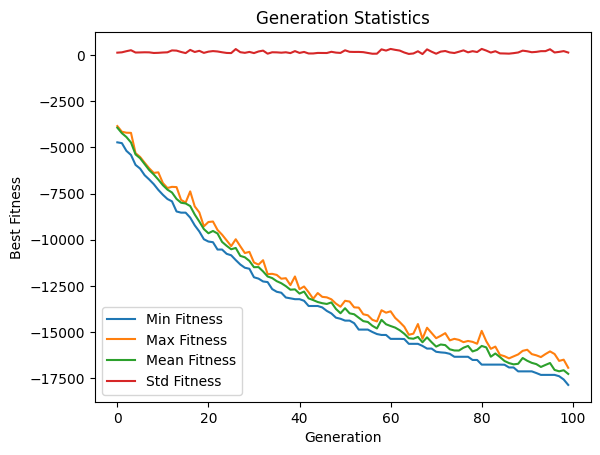

In [17]:
points_df = pd.read_csv('CaixeroGrupos.csv')

points_df.head()

grouped_points = points_df.groupby('GRUPO')

best_individual, df = genetic_algorithm(grouped_points, pop_size=100, num_generations=100, mutation_rate=0.001, elite_size=5)

df['Std Fitness'] = df['Score Fitness'].apply(np.std)

stats_df = df.groupby('Generation').agg({
    'Min Fitness': 'min',
    'Max Fitness': 'max',
    'Mean Fitness': 'mean',
    'Std Fitness': 'mean'
})

print(stats_df)

stats_df.plot(kind='line')
plt.title('Generation Statistics')
plt.ylabel('Best Fitness')
plt.show()